<a href="https://colab.research.google.com/github/XindaLi304/comp-5318-tutorial/blob/main/src/COMP5318_tutorial_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5318 - Machine Learning and Data Mining

## Tutorial 3 - Linear Regression and Logistic Regression

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score,train_test_split
%matplotlib inline

## 1. Linear Regression

#### 1.1 Data description

**House Prices dataset**:\
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

**Dataset files:**
- **train.csv** - the training set
- **test.csv** - the test set
- **data_description.txt** - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here

**Data fields**
Here's a brief version of what you'll find in the data description file.

- SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
- LotFrontage: Linear feet of street connected to property
- LotArea: Lot size in square feet
- Street: Type of road access
- Alley: Type of alley access
- LotShape: General shape of property
- TotalBsmtSF: Total square feet of basement area
- GrLivArea: Above grade (ground) living area square feet
- Kitchen: Number of kitchens
- KitchenQual: Kitchen quality
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- SaleType: Type of sale
- SaleCondition: Condition of sale
...

Load training data and testing data to dataframe pandas

In [ ]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 1. 2. Feature Extraction

####  1.2.1. Extract all features using for predict price

In [ ]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [ ]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'log(price + 1)'}>]], dtype=object)

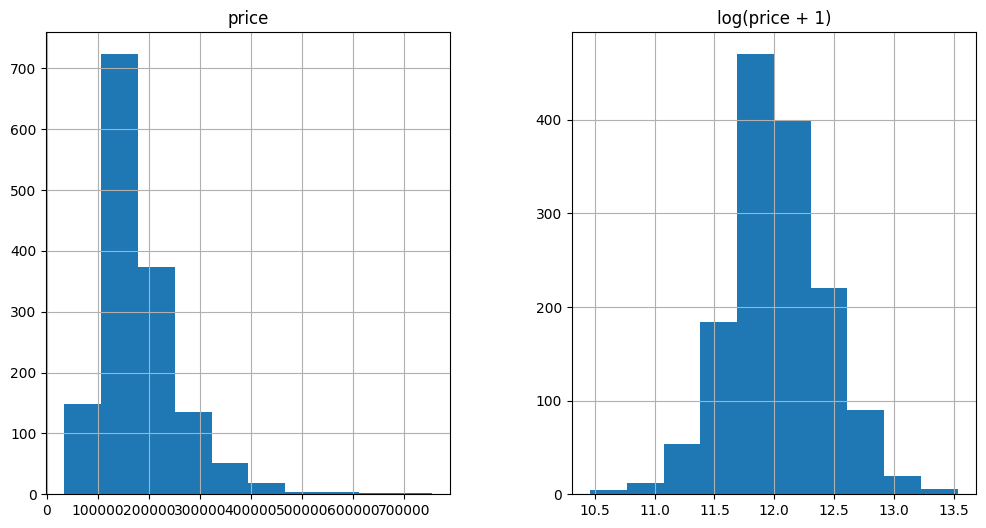

In [ ]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])}) #make
prices.hist()

#### 1.2.2 Data preprocessing:

- First, transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

In [ ]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])
test["SalePrice"] = np.log1p(test["SalePrice"])
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,4.110874,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal
1,3.044522,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal
2,4.110874,RL,4.234107,9.328212,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal
3,4.262680,RL,4.110874,9.164401,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml
4,4.110874,RL,4.442651,9.565284,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal


https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

In [ ]:
#filling NA's with the mean of the column:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())
all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,False,False,False,True,False,False,False,False,True,False
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,False,False,False,True,False,False,False,False,True,False
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,False,False,False,True,False,False,False,False,True,False
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,False,False,False,True,True,False,False,False,False,False
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,False,False,False,True,False,False,False,False,True,False


In [ ]:
# Separate training and testing data:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice
y_test = test.SalePrice

Visualize the relationship between some input features and the price

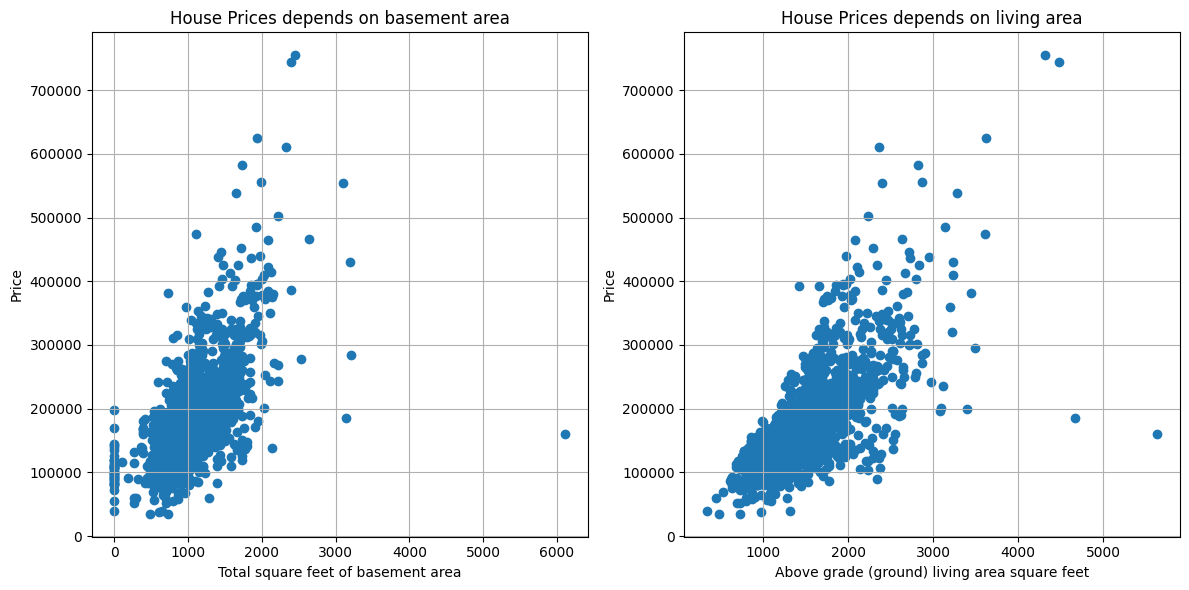

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)
axs = axs.flatten()
axs[0].scatter(X_train.TotalBsmtSF, y_train)
axs[0].set(xlabel='Total square feet of basement area', ylabel='Price',title='House Prices depends on basement area')
axs[0].grid()

axs[1].scatter(X_train.GrLivArea, y_train)
axs[1].set(xlabel='Above grade (ground) living area square feet', ylabel='Price',title='House Prices depends on living area')
axs[1].grid()

fig.tight_layout()
fig.show()

In [ ]:
# Made a prediction based on Living Area Feature

In [ ]:
X_Train = X_train.GrLivArea.to_numpy().reshape(-1,1)
X_Test = X_test.GrLivArea.to_numpy().reshape(-1,1)
y_Train = y_train.to_numpy().reshape(-1,1)
y_Test = y_test.to_numpy().reshape(-1,1)

### 1. 3. Linear Regression model

Linear model: $$y = Xw$$
Minimize Mean Squares Regression: \
 $$min_w ||y - Xw||^2 + \frac{\lambda}{2} * ||w||^2 $$

$\lambda$ is a regularization parameter

#### 1.3.1. Closed form solution:
* Closed form solution: $w = (X^TX + \lambda I)^{-1}X^Ty$

In [ ]:
import matplotlib.pylab as pl
%matplotlib inline
#
#w_0 = model_ridge.intercept_
#    w_1 = model_ridge.coef_
def plot(w_0, w_1, str_label):
    x0 = np.linspace(5.5, 9, 10, endpoint=True).reshape(-1,1)
    y0 = w_0 + x0.dot(w_1)
    plt.plot(x0, y0, label = str_label, color = 'r')
    #Grab the relevant data, scale the predictor variable, and add a column of 1s for the gradient descent...
    pl.scatter(X_Train, y_Train, marker='.', label = 'Training samples')
    pl.xlabel('Living Area')
    pl.ylabel('Price')
    pl.legend(loc='lower right')
    plt.title('Linear Problems')
    pl.grid()
    pl.show()

In [ ]:
one = np.ones((X_train.shape[0],1))
xTrainbar = np.concatenate((one, X_Train.reshape(-1, 1)), axis = 1)
Lambda = 0.1
A = np.dot(xTrainbar.T, xTrainbar) #+ Lambda
A_reg =  A + Lambda* np.identity(len(A))
b = np.dot(xTrainbar.T, y_Train)
wCF = np.dot(np.linalg.pinv(A), b)
print("Closed form Solution:",wCF)

Closed form Solution: [[18569.0258566 ]
 [  107.13035897]]


In [ ]:
xTrainbar.shape

(1460, 2)

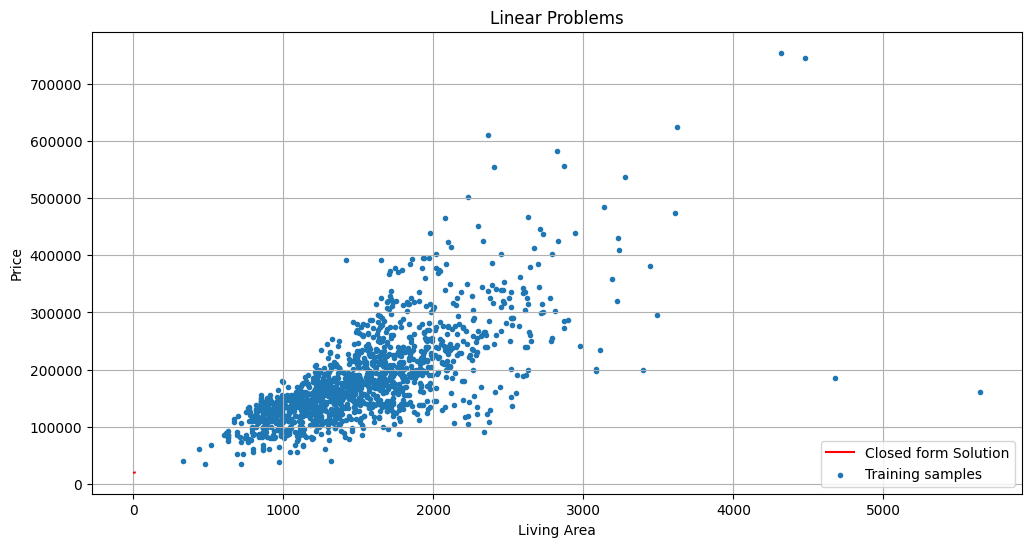

In [ ]:
plot(wCF[0], wCF[1],"Closed form Solution")

#### 1.3.2 Finding solution using Gradient Descent:
* Initialize $w =  w^{(0)}$ randomly:
* Choose learning rate $ \eta> 0$
*  Loop until convergence:

    Compute Gradient: $\nabla mse(w) = \frac{1}{N}(X^T(Xw-y) + \lambda * w)$
    
    Update parameters: $w^{t+1} = w^t - \eta * \nabla mse(w)$

In [94]:
# get all sample for each interation
def gradient_descent(x, y, w, iterations, eta, lamb):
    past_loss = []
    past_w = [w]
    n = y.size
    for i in range(iterations):
        prediction = np.dot(x, w)
        error = prediction - y
        loss = 1/(2*n) * np.dot(error.T, error)
        past_loss.append(loss)
        GradRmse = np.dot(x.T, error) + lamb*w
        #print(x.T.size)
        #print(error.size)

        w = w - (eta * (1/n) * GradRmse)
        past_w.append(w)

    return past_w, past_loss

In [95]:
# Todo: Implemenation for SGD, Mini-batch Sgd
import random

def stochastic_gradient_descent(x, y, w, iterations, eta, lamb):

    past_w = [w]
    n = y.size


    row=random.choice(range(x.shape[0]))


    x_item=x[row]
    y_item=y[row]

    prediction = np.dot(x_item, w)

    error = prediction - y_item#which is a scalar





    w = w - (eta  * error)*x_item
    past_w.append(w)


    return past_w




In [98]:
#testing sgd
eta = 0.01 #Step size
iterations = 5 #No. of iterations
w_init = np.array([6, 1]).reshape(-1,1)

wGD = stochastic_gradient_descent(xTrainbar, y_Train, w_init, iterations, eta, Lambda)

print(wGD)

[array([[6],
       [1]]), array([[2.33486000e+03, 4.90924288e+06],
       [2.32986000e+03, 4.90923788e+06]])]


In [99]:
#shuffle before defining the minibatch

def mini_batch_sgd(x, y, w, iterations, eta, lamb,batch_size):
  #shuffle data and spilit it into minibatches


  past_w = [w]

  indices = np.arange(x.shape[0])
  np.random.shuffle(indices)

  X_shuffled = x[indices]
  y_shuffled = y[indices]

  # Split into batches
  batches = [(X_shuffled[i:i + batch_size], y_shuffled[i:i + batch_size])
           for i in range(0, len(X_shuffled), batch_size)]
  for i in range(x.shape[0]//batch_size):

    #w_i+1=w_i-eta*[\sum(w_i.T * x_j - yj, for j in this batch)+lamb*w]
    cur_batch=batches[i]
    running_sum=0
    for j in range(batch_size):
      #print("x_j shape",cur_batch[0][j].shape)
      #print("y_j shape",cur_batch[1][j].shape)
      running_sum+=np.matmul(w.T,cur_batch[0][j])-cur_batch[1][j]
    w=w-eta*(running_sum+lamb*w)
    past_w.append(w)
  return past_w


In [101]:
#testing mini_batch_sgd
eta = 0.01 #Step size
batch_size = 100 #No. of iterations

w_init = np.array([6, 1]).reshape(-1,1)

wGD = mini_batch_sgd(xTrainbar, y_Train, w_init, iterations, eta, Lambda,batch_size)
print(wGD)

[array([[6],
       [1]]), array([[166889.824],
       [166884.829]]), array([[-2.48426387e+08],
       [-2.48426392e+08]]), array([[3.91284424e+11],
       [3.91284424e+11]]), array([[-5.92295449e+14],
       [-5.92295449e+14]]), array([[9.34702041e+17],
       [9.34702041e+17]]), array([[-1.42884256e+21],
       [-1.42884256e+21]]), array([[2.16509798e+24],
       [2.16509798e+24]]), array([[-3.20662053e+27],
       [-3.20662053e+27]]), array([[5.19979492e+30],
       [5.19979492e+30]]), array([[-7.9589673e+33],
       [-7.9589673e+33]]), array([[1.18783687e+37],
       [1.18783687e+37]]), array([[-1.86416862e+40],
       [-1.86416862e+40]]), array([[2.60165423e+43],
       [2.60165423e+43]]), array([[-3.82438228e+46],
       [-3.82438228e+46]])]


In [108]:

eta = 0.01 #Step size
iterations = 4 #No. of iterations
w_init = np.array([6, 1]).reshape(-1,1)
(wGD, pastLoss) = gradient_descent(xTrainbar, y_Train, w_init, iterations, eta, 10)
print(wGD[0])

print(wGD[-1])


[[6]
 [1]]
[[-3.02001863e+16]
 [-5.12662309e+19]]


#### 1.3.2 Finding solution using sklearn:

{'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
[5.66674083] [[0.874638]]


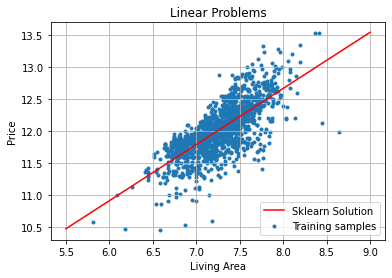

In [ ]:
model_ridge = Ridge(alpha = Lambda)
model_ridge.fit(X_Train, y_Train)
print(model_ridge.get_params())
print(model_ridge.intercept_,model_ridge.coef_)
plot(model_ridge.intercept_, model_ridge.coef_,"Sklearn Solution")

#### 1.4. Evaluation on test dataset

In [ ]:
# Todo: Evaluate Rmse on test data.

## 2. Logistic Regression

Logistic regression is used for classification tasks. Despite its name, logistic regression is a classification algorithm and should not be confused with linear regression.

#### Generate synthetic data belonged to 2 classes

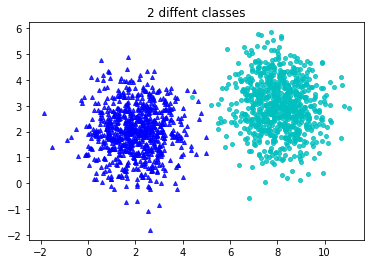

In [ ]:
C = 2# number of classes
N = 1000  # number of points per class
means = [[2, 2], [8, 3]]
cov = [[1, 0], [0, 1]]

X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)

X = np.concatenate((X0, X1), axis = 0) # each row is a datapoint
y = np.asarray([0]*N + [1]*N)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)

def display(X, label):
    X0 = X[np.where(label == 0)[0]]
    X1 = X[np.where(label == 1)[0]]
    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
    plt.plot(X1[:, 0], X1[:, 1], 'co', markersize = 4, alpha = .8)
    plt.plot()

display(X_train,y_train)
plt.title("2 diffent classes")
plt.show()

### 2.1 Logistic model

Minimize cross-entropy error:
$$f(w) = - \sum_{i=1}^n\{y_i\log \sigma(x_iw) + (1-y_i)\log [1- \sigma(x_iw)]\}$$

$$\sigma(z) = \frac{1}{exp(-z)}$$

Gradient of $f(w)$:
$$\nabla f(w) = \sum_{i=1}^n \{\sigma(x_iw) -y_i\}x_i$$

###  2.2 Gradient descent for logistic regression

In [ ]:
def sigmoid(S):
    """
    S: an numpy array
    return sigmoid function of each element of S
    """
    return 1/(1 + np.exp(-S))

def prob(w, X):
    """
    X: a 2d numpy array of shape (N, d). N datatpoint, each with size d
    w: a 1d numpy array of shape (d)
    """
    return sigmoid(X.dot(w))

def loss(w, X, y, lam):
    """
    X, w as in prob
    y: a 1d numpy array of shape (N). Each elem = 0 or 1
    """
    z = prob(w, X)
    return -np.mean(y*np.log(z) + (1-y)*np.log(1-z)) + 0.5*lam/X.shape[0]*np.sum(w*w)

def logistic_regression(w_init, X, y, lam = 0.001, lr = 0.1, nepoches = 2000):
    # lam - reg paramether, lr - learning rate, nepoches - number of epoches
    N, d = X.shape[0], X.shape[1]
    w = w_old = w_init
    loss_hist = [loss(w_init, X, y, lam)] # store history of loss in loss_hist
    ep = 0
    while ep < nepoches:
        ep += 1
        mix_ids = np.random.permutation(N)
        for i in mix_ids:
            xi = X[i]
            yi = y[i]
            zi = sigmoid(xi.dot(w))
            w = w - lr*((zi - yi)*xi + lam*w)
        loss_val = loss(w, X, y, lam)
        loss_hist.append(loss_val)
        if np.linalg.norm(w - w_old)/d < 1e-6:
            break
        w_old = w
    return w, loss_hist

def predict(w, X, threshold = 0.5):
    """
    predict output of each row of X
    X: a numpy array of shape (N, d)
    threshold: a threshold between 0 and 1
    return a 1d numpy array, each element is 0 or 1
    """
    res = np.zeros(X.shape[0])
    res[np.where(prob(w, X) > threshold)[0]] = 1
    return res

In [ ]:
def plot_logistic(w):
    xm = np.arange(-2, 12, 0.025)
    xlen = len(xm)
    ym = np.arange(-2, 7, 0.025)
    ylen = len(ym)
    xx, yy = np.meshgrid(xm, ym)
    xx1 = xx.ravel().reshape(-1, 1)
    yy1 = yy.ravel().reshape(-1, 1)
    XX = np.concatenate(( xx1, yy1, np.ones(( xx.size, 1))), axis = 1)
    Z = predict(w, XX)
    Z = Z.reshape(xx.shape)
    CS = plt.contourf(xx, yy, Z, 100, alpha = .1)
    plt.title("Final patten for each class")
    display(X, y)
    plt.show()

[  2.59529356   0.06964435 -13.09540574]
Accuracy 99.80 %


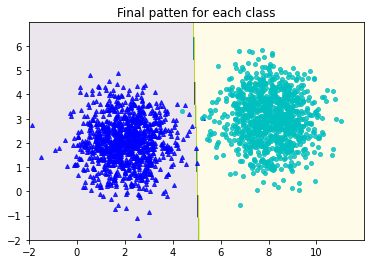

In [ ]:
# bias trick
Xbar_train = np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis = 1)
Xbar_test = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis = 1)

# randomly initial weight parameters
w_init = np.random.randn(Xbar_train.shape[1])

# training model
w, loss_hist = logistic_regression(w_init, Xbar_train, y_train, lam = 0.0001, lr = 0.05, nepoches = 1000)
y_predict = predict(w, Xbar_test)

print(w)
print("Accuracy %.2f %%" % (100*accuracy_score(y_test, y_predict)))
plot_logistic(w)

### 2.3 Compare with model from sklearn

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Accuracy on trainig set:", logreg.score(X_train, y_train)*100)
print("Accuracy on test set:", logreg.score(X_test, y_test)*100)

Accuracy on trainig set: 99.8
Accuracy on test set: 99.8


/Users/charlie/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
